# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparatifs](#init)
* [2. Recherche de la `taille de Tokenization` la plus adaptée](#TOKENSIZE)
    * [2.1 Tokenisation avec 100K samples](#TOKENSIZE_100K)
        * [1000 Tokens](#TOKENSIZE_1000)
        * [2500 Tokens](#TOKENSIZE_2500)
        * [5000 Tokens](#TOKENSIZE_5000)
        * [7500 Tokens](#TOKENSIZE_7500)
        * [10000 Tokens](#TOKENSIZE_10000)
        * [15000 Tokens](#TOKENSIZE_15000)
        * [20000 Tokens](#TOKENSIZE_20000)
        * [50000 Tokens](#TOKENSIZE_50000)
        * [100 Tokens](#TOKENSIZE_100)
        * [4000 Tokens](#TOKENSIZE_4000)
        * [6000 Tokens](#TOKENSIZE_6000)
        * [3000 Tokens](#TOKENSIZE_3000)
        * [3500 Tokens](#TOKENSIZE_3500)
        * [4500 Tokens](#TOKENSIZE_4500)
    * [2.2 Tokenisation avec tout le jeu de données](#TOKENSIZE_full)
    * [2.3 Comparaison des scores](#TOKENIZE_scores)

In [1]:
import os
import time
import pathlib

import joblib
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
try:
    from keras.utils import pad_sequences
except ImportError:
    from keras.preprocessing.sequence import pad_sequences

import joblib

random_seed = 0
np.random.seed(random_seed)

# set random seed for keras reproductibility
try:
    keras.utils.set_random_seed(random_seed)
except Exception:
    tf.random.set_seed(random_seed)

2022-08-02 16:06:03.808177: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


---
---
# 1. Préparatifs pour de la classification avec des réseaux de neurones <a class="anchor" id="init"></a> [⇪](#menu)

#### Chargeons les fonctions de classification écrites sur les projets précédents

In [2]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_NN.csv")

#### Définissons les fonctions génériques de notre Spot Checking 

In [3]:
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, ReduceLROnPlateau

In [4]:
def summarize_diagnostics(history):
    
    figure = plt.figure(figsize=(8,8))
            
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='val')
    plt.legend()
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='val')
    plt.legend()
    
    # save plot to file
    #filename = sys.argv[0].split('/')[-1]
    #plt.savefig(filename + '_plot.png')
    #plt.close()
    
    plt.tight_layout(pad=1.0)

In [5]:
def init_callbacks(model_name):

    # Define savepoints
    filepath = pathlib.Path("models", f"{model_name}.epoch{{epoch:02d}}-accuracy{{val_accuracy:.2f}}.hdf5")

    checkpoint = ModelCheckpoint(
        monitor="val_accuracy",
        mode="max",
        filepath=filepath,
        save_best_only=True,
        save_weights_only=True,
        verbose=1,
    )

    # Define EarlyStopping conditions
    es = EarlyStopping(
        monitor='val_loss', # 'binary_accuracy'
        mode='min', # 'max'
        patience=10,  # 6 because ReduceLROnPlateau is 5 
        min_delta=0.01, 
        restore_best_weights=True, 
        verbose=1,
    )

    # Define Automatic LearningRate adjustments
    lr_reducer = ReduceLROnPlateau(
        monitor='val_loss',
        mode='min',
        factor=0.1,
        cooldown=5,
        patience=5,
        min_lr= 0.1e-5,
        verbose=1,
    )
    
    return [checkpoint, es, lr_reducer]

#### Définissons une méthode de `cross-validation`

In [6]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

#### Définissons la taille de batch utilisé

In [7]:
batch_size = 8192 # 4096

---
---
# 2. Recherche de la `taille de Tokenization` la plus adaptée <a class="anchor" id="TOKENSIZE"></a> [⇪](#menu)

Pour rechercher le pré-traitement le plus adapté, nous allons essayer différents jeux de données préparés lors de l'EDA.
Mais pour éviter tout autre changement, nous allons dans un premier temps définir une architecture NN simple et un Embedding de base que nous allons utiliser pour comparer l'influence des différents pré-traitement.

In [8]:
def architecture01(f_opti, f_loss, f_metrics, embedding):
        
    inputs = keras.Input(shape=(None,), dtype="int64")
    
    x = embedding(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dense(24, activation='relu')(x)
    
    predictions = layers.Dense(1, activation='sigmoid', name='predictions')(x)
    
    model = keras.Model(inputs, predictions)
    model.compile(loss=f_loss, optimizer=f_opti, metrics=f_metrics)
    
    return model

### Chargeons le jeu de données avec toutes les étapes de pré-processing faites dans 01_EDA.ipynb

In [9]:
data_full = pd.read_csv(pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_1563108.csv'))
display(data_full.head(), data_full.shape)

,target,text,text_clean,tokens,tokens_filtered_advanced,tokens_filtered_simple,lemmas_filtered_advanced,lemmas_filtered_simple,lemmas_not_filtered
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","$URL$ - Awww, that's a bummer. You shoulda got...","$ url$ - awww , that 's a bummer . you shoulda...",bummer shoulda got day d,bummer shoulda got day d,bummer shoulda get day d,bummer shoulda get day d,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,is upset that he can't update his Facebook by ...,is upset that he can't update his Facebook by ...,is upset that he ca n't update his facebook by...,upset update facebook texting cry result schoo...,upset update facebook texting cry result schoo...,upset update facebook texte cry result school ...,upset update facebook texte cry result school ...,be upset that he can not update his facebook b...
2,0,@Kenichan I dived many times for the ball. Man...,I dived many times for the ball. Managed to sa...,i dived many times for the ball . managed to s...,dived times ball managed save 50 % rest bounds,dived times ball managed save 50 % rest bounds,dive time ball manage save 50 % rest bound,dive time ball manage save 50 % rest bound,I dive many time for the ball . manage to save...
3,0,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire,body feels itchy like fire,body feels itchy like fire,body feel itchy like fire,body feel itchy like fire,my whole body feel itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all....","no, it's not behaving at all. i'm mad. why am ...","no , it 's not behaving at all . i 'm mad . wh...",behaving mad,behaving mad,behave mad,behave mad,"no , it be not behave at all . I be mad . why ..."


(1452791, 9)

### Préparons les jeux de données des differents pré-processing

In [10]:
data_raw = data_full[['target','text']]
print("\n", " DATA RAW ".center(55, '-'))
display(data_raw.head(2), data_raw.shape)

data_preprocess_01 = data_full[['target','text_clean']]
print("\n", " DATA TWITTER-PREPROCESS ".center(55, '-'))
display(data_preprocess_01.head(2), data_preprocess_01.shape)

data_preprocess_02 = data_full[['target','tokens']]
print("\n", " DATA SpaCy TOKENS ".center(55, '-'))
display(data_preprocess_02.head(2), data_preprocess_02.shape)

data_preprocess_03 = data_full[['target','tokens_filtered_advanced']]
print("\n", " DATA SpaCy FILTERED TOKENS ".center(55, '-'))
display(data_preprocess_03.head(2), data_preprocess_03.shape)

data_preprocess_03_simple = data_full[['target','tokens_filtered_simple']]
print("\n", " DATA SpaCy FILTERED TOKENS (avec filtrage simple) ".center(55, '-'))
display(data_preprocess_03.head(2), data_preprocess_03.shape)

data_preprocess_04 = data_full[['target','lemmas_filtered_advanced']]
print("\n", " DATA SpaCy LEMMAS ".center(55, '-'))
display(data_preprocess_04.head(2), data_preprocess_04.shape)

data_preprocess_04_simple = data_full[['target','lemmas_filtered_simple']]
print("\n", " DATA SpaCy LEMMAS (avec filtrage simple) ".center(55, '-'))
display(data_preprocess_04.head(2), data_preprocess_04.shape)

data_preprocess_04_nofilter = data_full[['target','lemmas_not_filtered']]
print("\n", " DATA SpaCy LEMMAS (SANS filtrage) ".center(55, '-'))
display(data_preprocess_04_nofilter.head(2), data_preprocess_04_nofilter.shape)


 ----------------------- DATA RAW ----------------------


,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...


(1452791, 2)


 --------------- DATA TWITTER-PREPROCESS ---------------


,target,text_clean
0,0,"$URL$ - Awww, that's a bummer. You shoulda got..."
1,0,is upset that he can't update his Facebook by ...


(1452791, 2)


 ------------------ DATA SpaCy TOKENS ------------------


,target,tokens
0,0,"$ url$ - awww , that 's a bummer . you shoulda..."
1,0,is upset that he ca n't update his facebook by...


(1452791, 2)


 -------------- DATA SpaCy FILTERED TOKENS -------------


,target,tokens_filtered_advanced
0,0,bummer shoulda got day d
1,0,upset update facebook texting cry result schoo...


(1452791, 2)


 -- DATA SpaCy FILTERED TOKENS (avec filtrage simple) --


,target,tokens_filtered_advanced
0,0,bummer shoulda got day d
1,0,upset update facebook texting cry result schoo...


(1452791, 2)


 ------------------ DATA SpaCy LEMMAS ------------------


,target,lemmas_filtered_advanced
0,0,bummer shoulda get day d
1,0,upset update facebook texte cry result school ...


(1452791, 2)


 ------- DATA SpaCy LEMMAS (avec filtrage simple) ------


,target,lemmas_filtered_advanced
0,0,bummer shoulda get day d
1,0,upset update facebook texte cry result school ...


(1452791, 2)


 ---------- DATA SpaCy LEMMAS (SANS filtrage) ----------


,target,lemmas_not_filtered
0,0,"$ url$ - awww , that be a bummer . you shoulda..."
1,0,be upset that he can not update his facebook b...


(1452791, 2)

### Chargeons le jeu de données avec lequel nous allons faire cette recherche d'hyper-paramètre

In [11]:
sample_size = 100000
data_preprocess_04_nofilter = data_preprocess_04_nofilter.sample(sample_size, random_state=random_seed)

In [12]:
display(data_preprocess_04_nofilter.head(2), data_preprocess_04_nofilter.shape)

,target,lemmas_not_filtered
647137,0,go watch the proposal with claire . cloudy day...
531457,0,just remember can not go out late tonight due ...


(100000, 2)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_preprocess_04_nofilter['lemmas_not_filtered'], data_preprocess_04_nofilter.target, test_size=0.2, random_state=random_seed)

In [14]:
display(X_train.head(2), X_train.shape)

360695    do I take it you haz more tv station than I do...
405818    show some compassion . they work in fastfood a...
Name: lemmas_not_filtered, dtype: object

(80000,)

### Définissons une fonction permattant de Tokenizer notre jeu de données

In [15]:
def preprocess_data_RAW(X_train, X_test, tokenizer_num_words=2000, padding_size=35, verbose=1):
    tokenizer = Tokenizer(num_words=tokenizer_num_words)
    tokenizer.fit_on_texts(X_train)

    dictionary = tokenizer.word_index
    vocab_size = len(dictionary)+1 # Adding 1 because of reserved 0 index
    
    X_train_enc = tokenizer.texts_to_sequences(X_train)
    X_test_enc = tokenizer.texts_to_sequences(X_test)
    
    X_train_ready = pad_sequences(X_train_enc, padding='post', maxlen=padding_size)
    X_test_ready = pad_sequences(X_test_enc, padding='post', maxlen=padding_size)
    
    # y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
    # y_test = np.asarray(y_test).astype('float32').reshape((-1,1))
    
    if verbose > 0:
        print("----- One sample outputs for demo -----")
        print(f">> Original sentence: {X_train.iloc[0]}\n")
        print(f">> Tokenized sentence: {tokenizer.sequences_to_texts(X_train_ready[:1])}\n")
        print(f">> X_train_enc: {X_train_enc[:1]}\n")
        print(f">> X_train_ready: {X_train_ready[:1]}")
        
        print(f"\nVocab size: {vocab_size}")
    
    return X_train_ready, X_test_ready, tokenizer, vocab_size

### Définissons une fonction pour préparer le corpus avec le nombre de tokens demandé puis entrainer le modèle avec ce corpus

In [16]:
token_scores = {}

def search_num_tokens(token_num_words):
    
    print(f"Testing model with {token_num_words} tokens".upper().center(100,"-"), end='\n\n')
    
    padding_size = 50
    X_train_ready, X_test_ready, tokenizer, vocab_size = preprocess_data_RAW(X_train, X_test, token_num_words, padding_size)
    
    embedding_dim = 100
    embedding = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=padding_size, trainable=True)
    
    
    f_opti = keras.optimizers.Adam(learning_rate=0.0005)
    f_loss = keras.losses.BinaryCrossentropy(from_logits=False)
    f_metrics = ['accuracy'] # in this context 'accuracy' == keras.metrics.BinaryAccuracy()
    
    model = architecture01(f_opti, f_loss, f_metrics, embedding)
    # archi01_model_RAW.summary()
    
    # t0 = time.perf_counter()
    history = model.fit(
        x=X_train_ready, y=y_train, 
        validation_data=(X_test_ready, y_test), 
        epochs=50, 
        batch_size=batch_size, 
        callbacks=init_callbacks(f"archi01_{token_num_words}Tokens"),
        verbose=0,
        # validation_split=0.2,
        # train_labels
    )
    # train_time = time.perf_counter() - t0
    summarize_diagnostics(history)
    
    loss, accuracy = model.evaluate(X_train_ready, y_train, verbose=False)
    print("\nTraining Accuracy: {:.4f}".format(accuracy))
    loss, accuracy = model.evaluate(X_test_ready, y_test, verbose=False)
    print("Testing Accuracy:  {:.4f}".format(accuracy))
    
    token_scores[token_num_words] = accuracy

---
## 2.1 Essais avec une fraction du jeu de données (100K) pour aller plus vite <a class="anchor" id="TOKENSIZE_100K"></a> [⇪](#menu)

### Essai avec 1000 Tokens <a class="anchor" id="TOKENSIZE_1000"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 1000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you more tv than i do watch the not here']

>> X_train_enc: [[12, 1, 105, 9, 10, 85, 413, 190, 1, 12, 73, 4, 6, 87]]

>> X_train_ready: [[ 12   1 105   9  10  85 413 190   1  12  73   4   6  87   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.58595, saving model to models/archi01_1000Tokens.epoch01-accuracy0.59.hdf5

Epoch 00002: val_accuracy improved from 0.58595 to 0.60105, saving model to models/archi01_1000Tokens.epoch02-accuracy0.60.hdf5

Epoch 00003: val_accuracy improved from 0.60105 to 0.63550, saving model to models/archi01_100

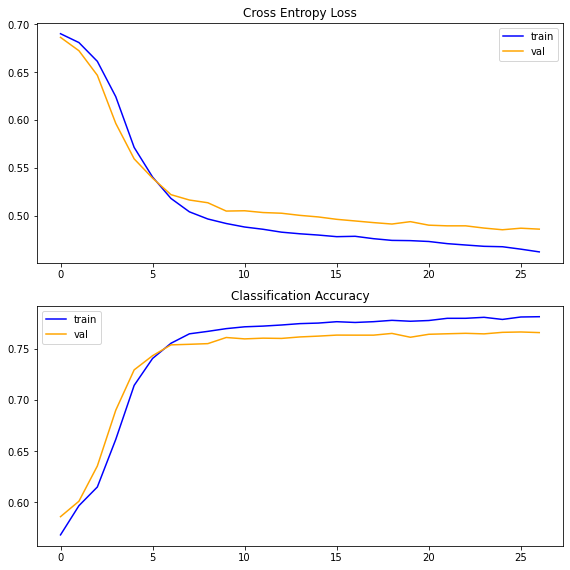

In [18]:
search_num_tokens(1000)

In [19]:
token_scores

{1000: 0.7634999752044678}

### Essai avec 2500 Tokens <a class="anchor" id="TOKENSIZE_2500"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 2500 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you more tv station than i do watch the not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 85, 413, 1286, 190, 1, 12, 73, 4, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10   85  413 1286  190    1   12   73    4    6
  1135   87    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.57875, saving model to models/archi01_2500Tokens.epoch01-accuracy0.58.hdf5

Epoch 00002: val_accuracy improved from 0.57875 to 0.59595, saving model to models/archi01_2500Tokens.epoch02-accuracy0.60.hdf5

Epoch 00003: 

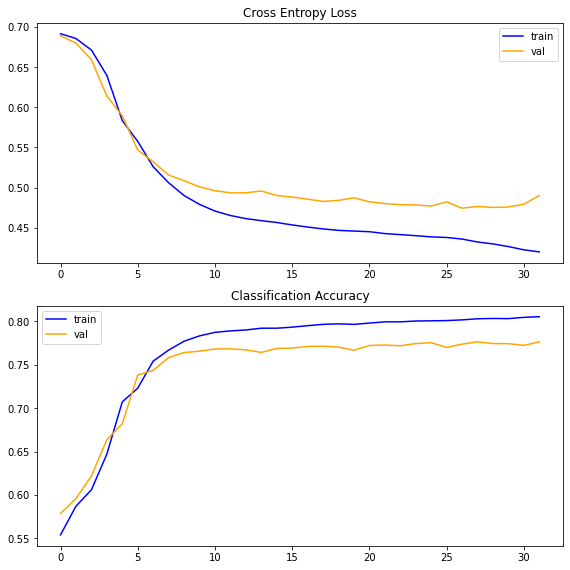

In [20]:
search_num_tokens(2500)

In [21]:
token_scores

{1000: 0.7634999752044678, 2500: 0.7727500200271606}

### Essai avec 5000 Tokens <a class="anchor" id="TOKENSIZE_5000"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 5000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
     6 1135   87    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.60510, saving model to models/archi01_5000Tokens.epoch01-accuracy0.61.hdf5

Epoch 00002: val_accuracy improved from 0.60510 to 0.60540, saving model to models/archi01_5000Tokens.epoch02-accuracy0.61.hdf5

Epo

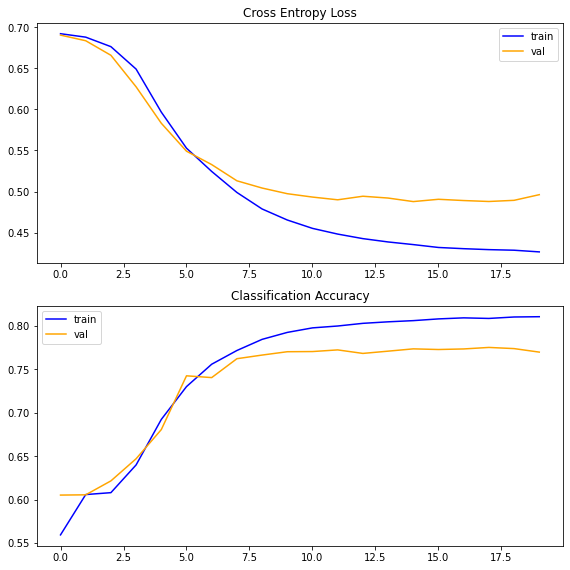

In [22]:
search_num_tokens(5000)

In [23]:
token_scores

{1000: 0.7634999752044678, 2500: 0.7727500200271606, 5000: 0.7702500224113464}

### Essai avec 7500 Tokens <a class="anchor" id="TOKENSIZE_7500"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 7500 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the footie not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6411, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
  6411    6 1135   87    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.57195, saving model to models/archi01_7500Tokens.epoch01-accuracy0.57.hdf5

Epoch 00002: val_accuracy improved from 0.57195 to 0.59570, saving model to models/archi01_7500Tokens.epoch02-accuracy0

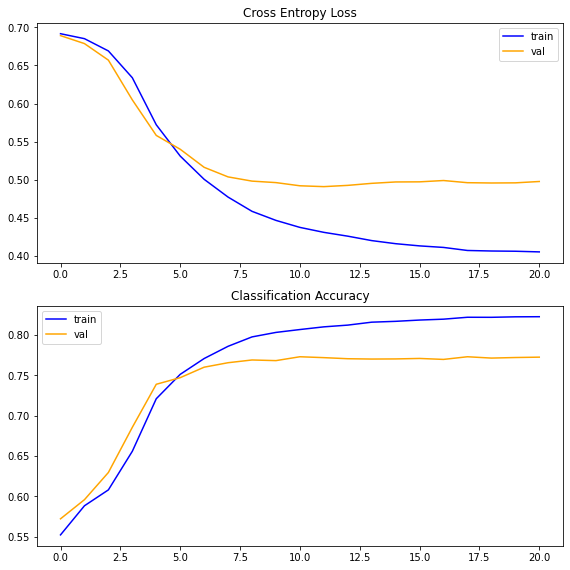

In [25]:
search_num_tokens(7500)

In [26]:
token_scores

{1000: 0.7634999752044678,
 2500: 0.7727500200271606,
 5000: 0.7702500224113464,
 7500: 0.7730500102043152}

### Essai avec 10000 Tokens <a class="anchor" id="TOKENSIZE_10000"></a> [⇪](#menu)

----------------------------------TESTING MODEL WITH 10000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the footie not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6411, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
  6411    6 1135   87    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.56625, saving model to models/archi01_10000Tokens.epoch01-accuracy0.57.hdf5

Epoch 00002: val_accuracy improved from 0.56625 to 0.61795, saving model to models/archi01_10000Tokens.epoch02-accurac

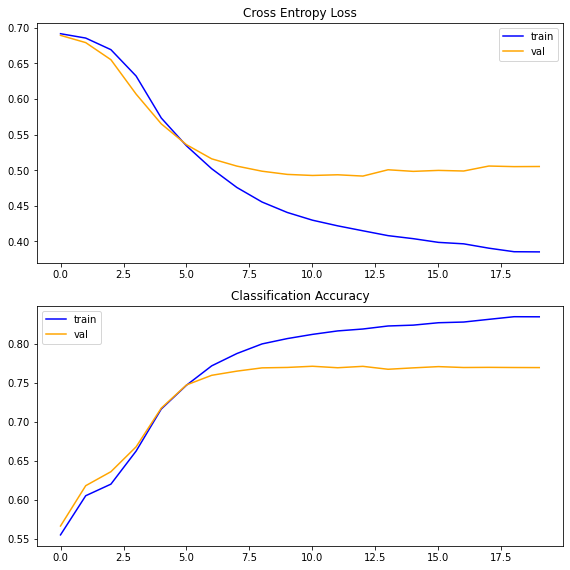

In [27]:
search_num_tokens(10000)

In [28]:
token_scores

{1000: 0.7634999752044678,
 2500: 0.7727500200271606,
 5000: 0.7702500224113464,
 7500: 0.7730500102043152,
 10000: 0.7696499824523926}

### Essai avec 15000 Tokens <a class="anchor" id="TOKENSIZE_15000"></a> [⇪](#menu)

----------------------------------TESTING MODEL WITH 15000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the footie not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6411, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
  6411    6 1135   87    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.59515, saving model to models/archi01_15000Tokens.epoch01-accuracy0.60.hdf5

Epoch 00002: val_accuracy improved from 0.59515 to 0.62435, saving model to models/archi01_15000Tokens.epoch02-accurac

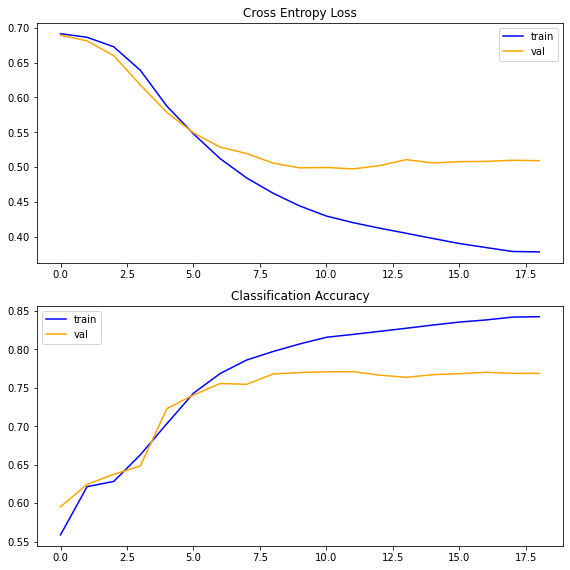

In [29]:
search_num_tokens(15000)

In [30]:
token_scores

{1000: 0.7634999752044678,
 2500: 0.7727500200271606,
 5000: 0.7702500224113464,
 7500: 0.7730500102043152,
 10000: 0.7696499824523926,
 15000: 0.7680000066757202}

### Essai avec 20000 Tokens <a class="anchor" id="TOKENSIZE_20000"></a> [⇪](#menu)

----------------------------------TESTING MODEL WITH 20000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the footie not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6411, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
  6411    6 1135   87    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.59810, saving model to models/archi01_20000Tokens.epoch01-accuracy0.60.hdf5

Epoch 00002: val_accuracy improved from 0.59810 to 0.60600, saving model to models/archi01_20000Tokens.epoch02-accurac

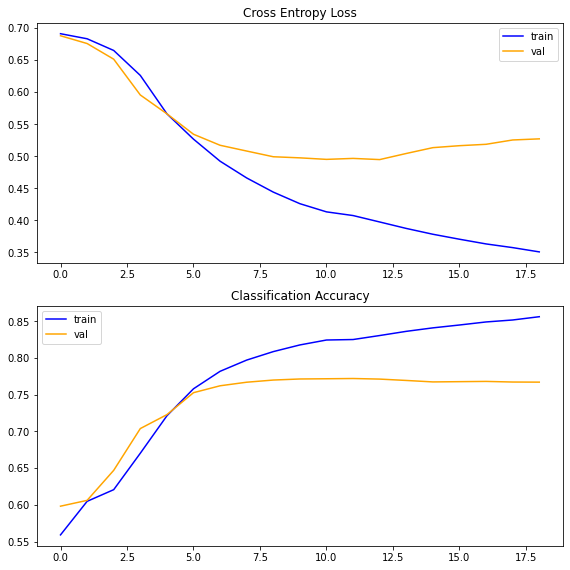

In [31]:
search_num_tokens(20000)

In [32]:
token_scores

{1000: 0.7634999752044678,
 2500: 0.7727500200271606,
 5000: 0.7702500224113464,
 7500: 0.7730500102043152,
 10000: 0.7696499824523926,
 15000: 0.7680000066757202,
 20000: 0.7698000073432922}

### Essai avec 50000 Tokens <a class="anchor" id="TOKENSIZE_50000"></a> [⇪](#menu)

----------------------------------TESTING MODEL WITH 50000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the footie not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6411, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
  6411    6 1135   87    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.58970, saving model to models/archi01_50000Tokens.epoch01-accuracy0.59.hdf5

Epoch 00002: val_accuracy improved from 0.58970 to 0.59275, saving model to models/archi01_50000Tokens.epoch02-accurac

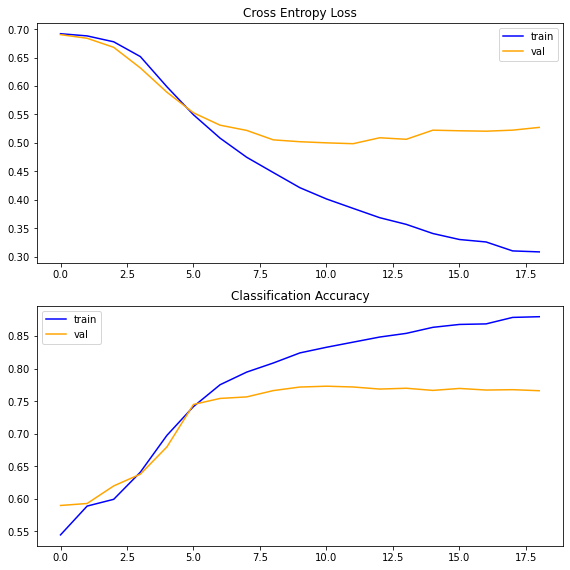

In [33]:
search_num_tokens(50000)

In [34]:
token_scores

{1000: 0.7634999752044678,
 2500: 0.7727500200271606,
 5000: 0.7702500224113464,
 7500: 0.7730500102043152,
 10000: 0.7696499824523926,
 15000: 0.7680000066757202,
 20000: 0.7698000073432922,
 50000: 0.7662500143051147}

### Essai avec 100 Tokens <a class="anchor" id="TOKENSIZE_100"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 100 TOKENS------------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i it you more i do watch the not here']

>> X_train_enc: [[12, 1, 9, 10, 85, 1, 12, 73, 4, 6, 87]]

>> X_train_ready: [[12  1  9 10 85  1 12 73  4  6 87  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.58365, saving model to models/archi01_100Tokens.epoch01-accuracy0.58.hdf5

Epoch 00002: val_accuracy did not improve from 0.58365

Epoch 00003: val_accuracy improved from 0.58365 to 0.59035, saving model to models/archi01_100Tokens.epoch03-accuracy0.59.hdf5

Epoch 00004: val_accuracy improved from 0.59035 to 0.61305, saving model to models/archi01_100Tokens.epoch04-accuracy0

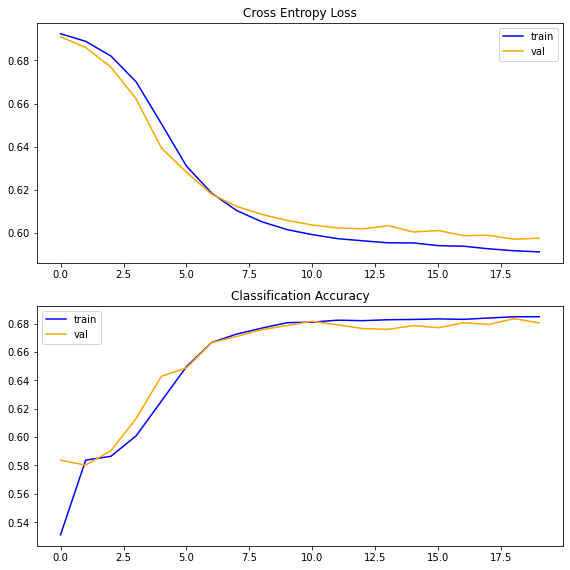

In [35]:
search_num_tokens(100)

In [36]:
token_scores

{1000: 0.7634999752044678,
 2500: 0.7727500200271606,
 5000: 0.7702500224113464,
 7500: 0.7730500102043152,
 10000: 0.7696499824523926,
 15000: 0.7680000066757202,
 20000: 0.7698000073432922,
 50000: 0.7662500143051147,
 100: 0.6786999702453613}

### Essai avec 4000 Tokens <a class="anchor" id="TOKENSIZE_4000"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 4000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
     6 1135   87    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.57720, saving model to models/archi01_4000Tokens.epoch01-accuracy0.58.hdf5

Epoch 00002: val_accuracy improved from 0.57720 to 0.59600, saving model to models/archi01_4000Tokens.epoch02-accuracy0.60.hdf5

Epo

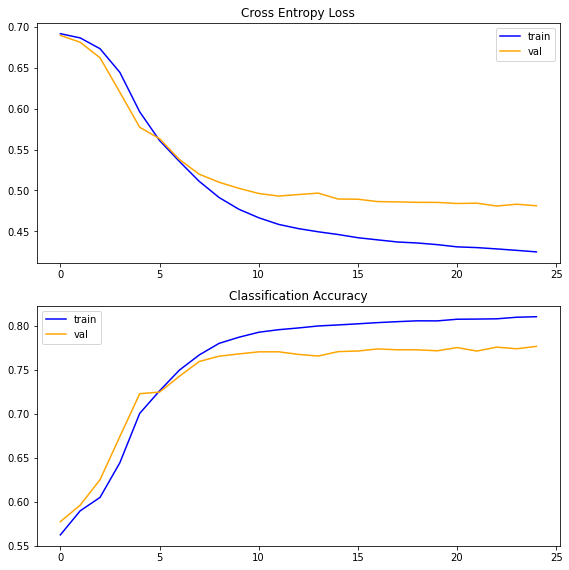

In [37]:
search_num_tokens(4000)

In [38]:
token_scores

{1000: 0.7634999752044678,
 2500: 0.7727500200271606,
 5000: 0.7702500224113464,
 7500: 0.7730500102043152,
 10000: 0.7696499824523926,
 15000: 0.7680000066757202,
 20000: 0.7698000073432922,
 50000: 0.7662500143051147,
 100: 0.6786999702453613,
 4000: 0.7706000208854675}

### Essai avec 6000 Tokens <a class="anchor" id="TOKENSIZE_6000"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 6000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
     6 1135   87    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.58000, saving model to models/archi01_6000Tokens.epoch01-accuracy0.58.hdf5

Epoch 00002: val_accuracy improved from 0.58000 to 0.59210, saving model to models/archi01_6000Tokens.epoch02-accuracy0.59.hdf5

Epo

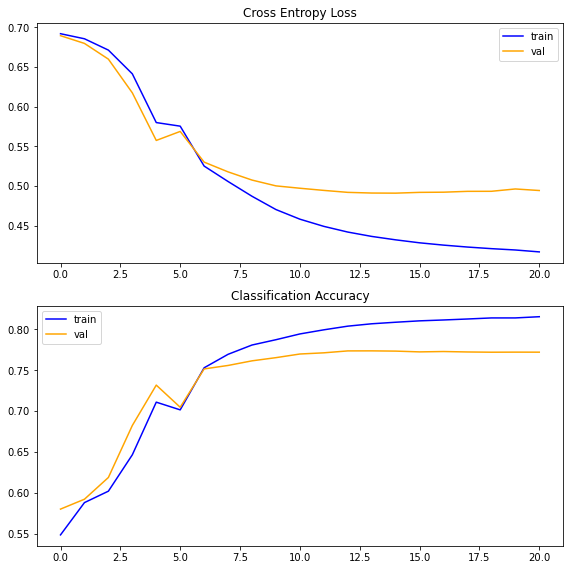

In [39]:
search_num_tokens(6000)

In [48]:
pd.Series(token_scores).sort_index()

100      0.67870
1000     0.76350
2500     0.77275
4000     0.77060
5000     0.77025
6000     0.76975
7500     0.77305
10000    0.76965
15000    0.76800
20000    0.76980
50000    0.76625
dtype: float64

### Essai avec 3000 Tokens <a class="anchor" id="TOKENSIZE_3000"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 3000 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you more tv station than i do watch the not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 85, 413, 1286, 190, 1, 12, 73, 4, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10   85  413 1286  190    1   12   73    4    6
  1135   87    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.58205, saving model to models/archi01_3000Tokens.epoch01-accuracy0.58.hdf5

Epoch 00002: val_accuracy improved from 0.58205 to 0.59380, saving model to models/archi01_3000Tokens.epoch02-accuracy0.59.hdf5

Epoch 00003: 

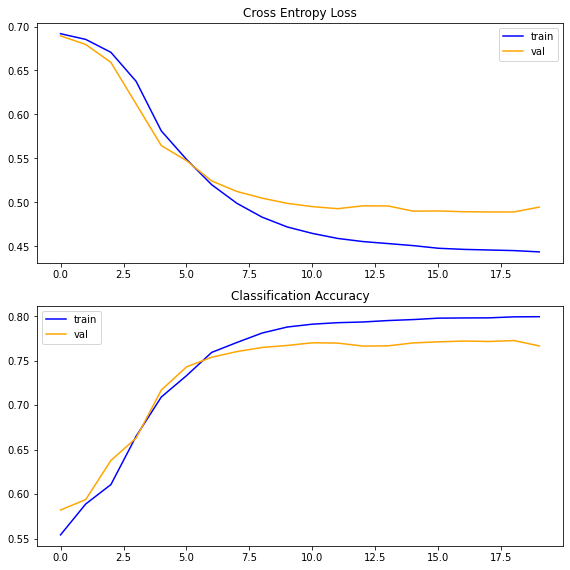

In [49]:
search_num_tokens(3000)

In [50]:
pd.Series(token_scores).sort_index()

100      0.67870
1000     0.76350
2500     0.77275
3000     0.76705
4000     0.77060
5000     0.77025
6000     0.76975
7500     0.77305
10000    0.76965
15000    0.76800
20000    0.76980
50000    0.76625
dtype: float64

### Essai avec 3500 Tokens <a class="anchor" id="TOKENSIZE_3500"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 3500 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you more tv station than i do watch the not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 85, 413, 1286, 190, 1, 12, 73, 4, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10   85  413 1286  190    1   12   73    4    6
  1135   87    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.58395, saving model to models/archi01_3500Tokens.epoch01-accuracy0.58.hdf5

Epoch 00002: val_accuracy improved from 0.58395 to 0.60315, saving model to models/archi01_3500Tokens.epoch02-accuracy0.60.hdf5

Epoch 00003: 

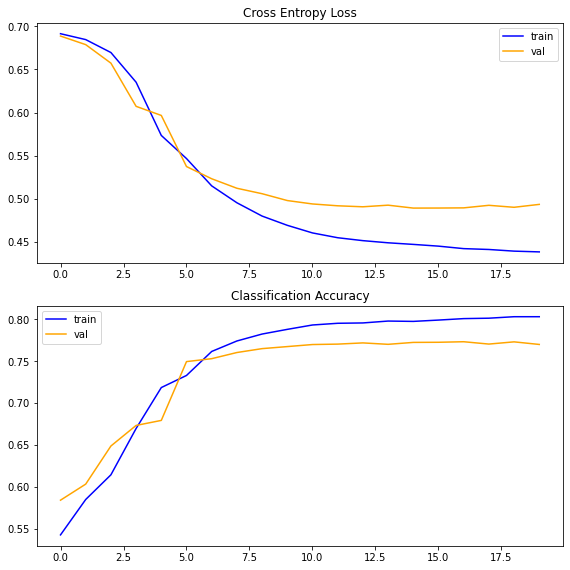

In [51]:
search_num_tokens(3500)

In [52]:
pd.Series(token_scores).sort_index()

100      0.67870
1000     0.76350
2500     0.77275
3000     0.76705
3500     0.76755
4000     0.77060
5000     0.77025
6000     0.76975
7500     0.77305
10000    0.76965
15000    0.76800
20000    0.76980
50000    0.76625
dtype: float64

### Essai avec 4500 Tokens <a class="anchor" id="TOKENSIZE_4500"></a> [⇪](#menu)

-----------------------------------TESTING MODEL WITH 4500 TOKENS-----------------------------------

----- One sample outputs for demo -----
>> Original sentence: do I take it you haz more tv station than I do ? watch the footie not possible here

>> Tokenized sentence: ['do i take it you haz more tv station than i do watch the not possible here']

>> X_train_enc: [[12, 1, 105, 9, 10, 3606, 85, 413, 1286, 190, 1, 12, 73, 4, 6, 1135, 87]]

>> X_train_ready: [[  12    1  105    9   10 3606   85  413 1286  190    1   12   73    4
     6 1135   87    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]

Vocab size: 42801

Epoch 00001: val_accuracy improved from -inf to 0.56540, saving model to models/archi01_4500Tokens.epoch01-accuracy0.57.hdf5

Epoch 00002: val_accuracy improved from 0.56540 to 0.62015, saving model to models/archi01_4500Tokens.epoch02-accuracy0.62.hdf5

Epo

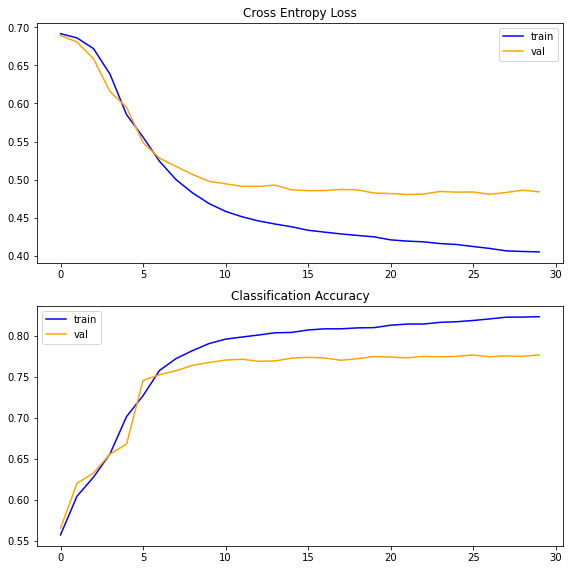

In [53]:
search_num_tokens(4500)

In [54]:
pd.Series(token_scores).sort_index()

100      0.67870
1000     0.76350
2500     0.77275
3000     0.76705
3500     0.76755
4000     0.77060
4500     0.77445
5000     0.77025
6000     0.76975
7500     0.77305
10000    0.76965
15000    0.76800
20000    0.76980
50000    0.76625
dtype: float64

>### On constate que la taille idéale de Tokens pour ce jeu de données se situe autour de **4500 tokens**.

---
## 2.2 Essais avec tout le jeu de données <a class="anchor" id="TOKENSIZE_full"></a> [⇪](#menu)

>#### **Ces tests ont été fait avant les test avec 100K samples**, mais comme c'était assez long, j'ai vérifié si on avant la même tendance avec 100K *(ce qui est le cas)* avant d'affiner la recherche.

In [ ]:
for t_size in [1000, 5000, 10000, 20000, 30000, 40000, 50000]:
    search_num_tokens(t_size)

Testing model with 1000 tokens
----- One sample outputs for demo -----
>> Original sentence: you too be fake .. :x ... disguise your link to be something else .

>> Tokenized sentence: ['you too be x your link to be something else']

>> X_train_enc: [[10, 46, 2, 197, 44, 456, 3, 2, 199, 447]]

>> X_train_ready: [[ 10  46   2 197  44 456   3   2 199 447   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]]

Vocab size: 228026


2022-08-01 20:50:50.058766: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-01 20:50:50.059714: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-01 20:50:50.111355: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 20:50:50.111907: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:1e.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.75GiB deviceMemoryBandwidth: 298.08GiB/s
2022-08-01 20:50:50.111952: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-08-01 20:50:50.113559: I tensorflow/stream_executor/platform/default/dso_loade

Epoch 1/50


2022-08-01 20:50:52.561981: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 91210400 exceeds 10% of free system memory.
2022-08-01 20:50:53.793973: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2022-08-01 20:50:54.333898: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7


142/142 [==============================] - 54s 356ms/step - loss: 0.6221 - accuracy: 0.6507 - val_loss: 0.4911 - val_accuracy: 0.7707

Epoch 00001: val_accuracy improved from -inf to 0.77069, saving model to models/archi01_RAW.epoch01-accuracy0.77.hdf5
Epoch 2/50
142/142 [==============================] - 50s 352ms/step - loss: 0.4869 - accuracy: 0.7703 - val_loss: 0.4740 - val_accuracy: 0.7747

Epoch 00002: val_accuracy improved from 0.77069 to 0.77472, saving model to models/archi01_RAW.epoch02-accuracy0.77.hdf5
Epoch 3/50
142/142 [==============================] - 50s 352ms/step - loss: 0.4704 - accuracy: 0.7757 - val_loss: 0.4649 - val_accuracy: 0.7778

Epoch 00003: val_accuracy improved from 0.77472 to 0.77776, saving model to models/archi01_RAW.epoch03-accuracy0.78.hdf5
Epoch 4/50
142/142 [==============================] - 50s 351ms/step - loss: 0.4639 - accuracy: 0.7777 - val_loss: 0.4637 - val_accuracy: 0.7782

Epoch 00004: val_accuracy improved from 0.77776 to 0.77816, saving 

---
## 2.3 Comparaison des `scores` avec les différents pré-traitements <a class="anchor" id="TOKENIZE_scores"></a> [⇪](#menu)

### Les scores ci-dessous ont été obtenus avec 100K samples

In [54]:
pd.Series(token_scores).sort_index()

100      0.67870
1000     0.76350
2500     0.77275
3000     0.76705
3500     0.76755
4000     0.77060
4500     0.77445
5000     0.77025
6000     0.76975
7500     0.77305
10000    0.76965
15000    0.76800
20000    0.76980
50000    0.76625
dtype: float64

### Les scores ci-dessous ont été obtenus avec tout le jeu de données

>### Testing model with 1000 tokens
> - Training Accuracy: 0.7945
> - Testing Accuracy:  0.7923

>### Testing model with 5000 tokens
> - Training Accuracy: 0.8177
> - Testing Accuracy:  0.8108

>### Testing model with 10000 tokens
> - Training Accuracy: 0.8246
> - Testing Accuracy:  0.8143

>### Testing model with 20000 tokens
> - Training Accuracy: 0.8055
> - Testing Accuracy:  0.7979

>### Testing model with 30000 tokens
> - Training Accuracy: 0.8158
> - Testing Accuracy:  0.8011

>### Testing model with 40000 tokens
> - Training Accuracy: 0.7939
> - Testing Accuracy:  0.7884

>### Testing model with 50000 tokens
> - Training Accuracy: 0.7947
> - Testing Accuracy:  0.7882

>#### **Conclusion**:
> - Les recherches nous on permi de voir que le nombre de Tokens choisi **a une influence** sur les résultats de notre réseau de neuronnes
> - On devine un tendance similaire sur les essais avec 100K et les essais avec tout le jeu de données; un nombre de tokens optimal autour de 5000
> - En se basant sur les essais plus poussés en 100K samples, nous allons donc utiliser **4500 tokens pour la suite de notre projet**.